In [188]:
%autosave 0

Autosave disabled


# 4. Evaluation Metrics for Classification

In the previous session we trained a model for predicting churn. How do we know if it's good?


## 4.1 Evaluation metrics: session overview 

* Dataset: https://www.kaggle.com/blastchar/telco-customer-churn
* https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv


*Metric* - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are

In [189]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [190]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [191]:
df = pd.read_csv('data-week-3.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [192]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [193]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [194]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [195]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [196]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

## 4.2 Accuracy and dummy model

* Evaluate the model on different thresholds
* Check the accuracy of dummy baselines

In [197]:
len(y_val)

1409

In [198]:
(y_val == churn_decision).mean()

0.8034066713981547

In [199]:
1132/ 1409

0.8034066713981547

In [200]:
from sklearn.metrics import accuracy_score

In [201]:
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

In [202]:
# testing different thresholds
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


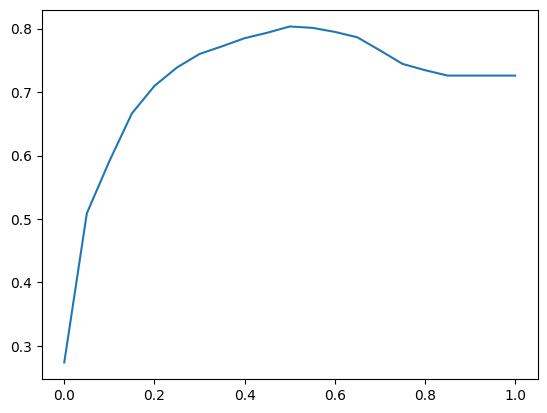

In [203]:
plt.plot(thresholds, scores)

In [204]:
from collections import Counter

In [205]:
Counter(y_pred >= 0.5) # class imbalance problem, accuracy is not a good metric to use

Counter({False: 1098, True: 311})

In [206]:
Counter(y_pred >= 1.0)

Counter({False: 1409})

In [207]:
1 - y_val.mean()

0.7260468417317246

## 4.3 Confusion table

* Different types of errors and correct decisions
* Arranging them in a table

<img src="confusion_matrix.jpg" width=1200 height=500 />

In [208]:
actual_positive = (y_val == 1) #true positive
actual_negative = (y_val == 0) #true negative

In [209]:
t = 0.5
predict_positive = (y_pred >= t) #false positive
predict_negative = (y_pred < t) #false negative

In [210]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [211]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

# we have a lot more false negatives than false positives, so the client will chrun even if we do not do anything
# for the false positives, we for example are offering a discount to keep the client, but we are losing money 

# we might want to optimize de model for precision or recall ?? next lesson

array([[922, 101],
       [176, 210]])

In [212]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

## 4.4 Precision and Recall

<img src="precision.jpg" width=1200 height=500 />

In [213]:
# precision is tell the fracion of the **true positive predictions among all positive predictions** - model related
p = tp / (tp + fp)
p

# we are sending the promotion to 33% of the clients that will not churn, so we are losing money

0.6752411575562701

<img src="recall.jpg" width=1200 height=500 />

In [214]:
# recall is the fraction of the true positive predictions among all actual positive instances - data related
r = tp / (tp + fn)
r

# we failed to identify 46% customers that will churn - we failed to retain them, because of more did not identify them for promotion offer

0.5440414507772021

- In this case for churn , the best metric is recall, because we want to identify all the customers that will churn

## 4.5 ROC Curves

### TPR and FRP

<img src="ROC_curves.jpg" width=1200 height=500 />

In [215]:
tpr = tp / (tp + fn)  # true positive rate - recall - maximizing this
tpr

0.5440414507772021

In [216]:
fpr = fp / (fp + tn) # false positive rate - minimizing this
fpr

# for all negative instances, we still predict 9% incorrectly as positive

0.09872922776148582

In [217]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [218]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

In [219]:
df_scores.head(10)

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.00,386,1023,0,0,1.000000,1.000000
1,0.01,385,913,1,110,0.997409,0.892473
2,0.02,384,830,2,193,0.994819,0.811339
3,0.03,383,766,3,257,0.992228,0.748778
4,0.04,381,715,5,308,0.987047,0.698925
5,0.05,379,685,7,338,0.981865,0.669599
6,0.06,377,661,9,362,0.976684,0.646139
7,0.07,372,641,14,382,0.963731,0.626588
8,0.08,371,613,15,410,0.961140,0.599218
9,0.09,369,580,17,443,0.955959,0.566960


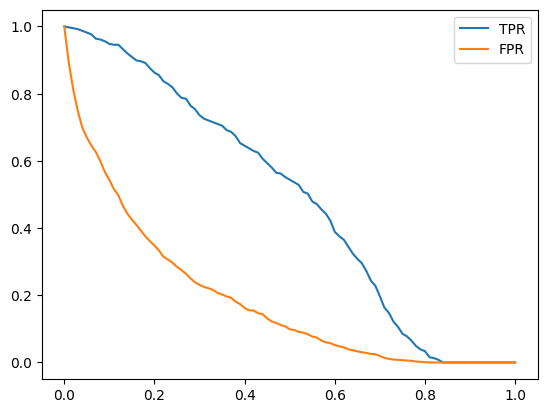

In [220]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend();

### Random model

In [221]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [222]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [223]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [224]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

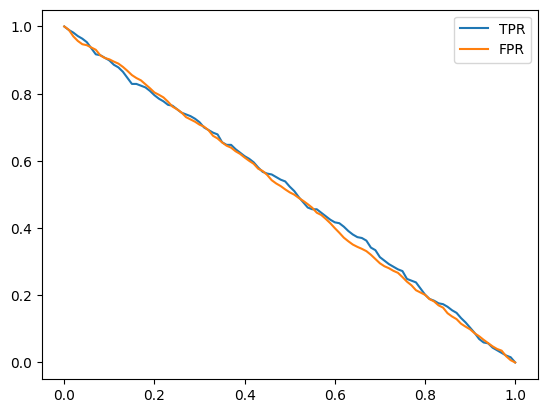

In [225]:
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend();

### Ideal model

In [226]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1023, 386)

In [227]:
# np.repeat([0, 1], [num_neg, num_pos]) - repeat 0 num_neg times and 1 num_pos times  - correct 100% of the time
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

# np.linspace(0, 1, len(y_val)) - 0 to 1 with the same length as y_val
y_ideal_pred = np.linspace(0, 1, len(y_val))

In [228]:
# this will be the threshold that will give us the best TPR and FPR
1 - y_val.mean()

0.7260468417317246

In [229]:
# the ideal model is able to predict 100% of the time the positive class
accuracy_score(y_ideal, y_ideal_pred >= 0.726)

1.0

In [230]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,882,0,141,1.000000,0.862170
20,0.2,386,741,0,282,1.000000,0.724340
30,0.3,386,600,0,423,1.000000,0.586510
40,0.4,386,459,0,564,1.000000,0.448680
50,0.5,386,319,0,704,1.000000,0.311828
60,0.6,386,178,0,845,1.000000,0.173998
70,0.7,386,37,0,986,1.000000,0.036168
80,0.8,282,0,104,1023,0.730570,0.000000
90,0.9,141,0,245,1023,0.365285,0.000000


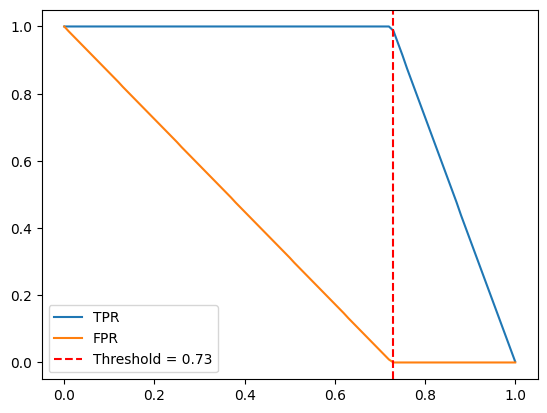

In [231]:
threshold_ideal = round(1 - y_val.mean(),2)  # specify the threshold value

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.axvline(x=threshold_ideal, color='red', linestyle='--', label=f'Threshold = {threshold_ideal}')
plt.legend();

### Putting everything together

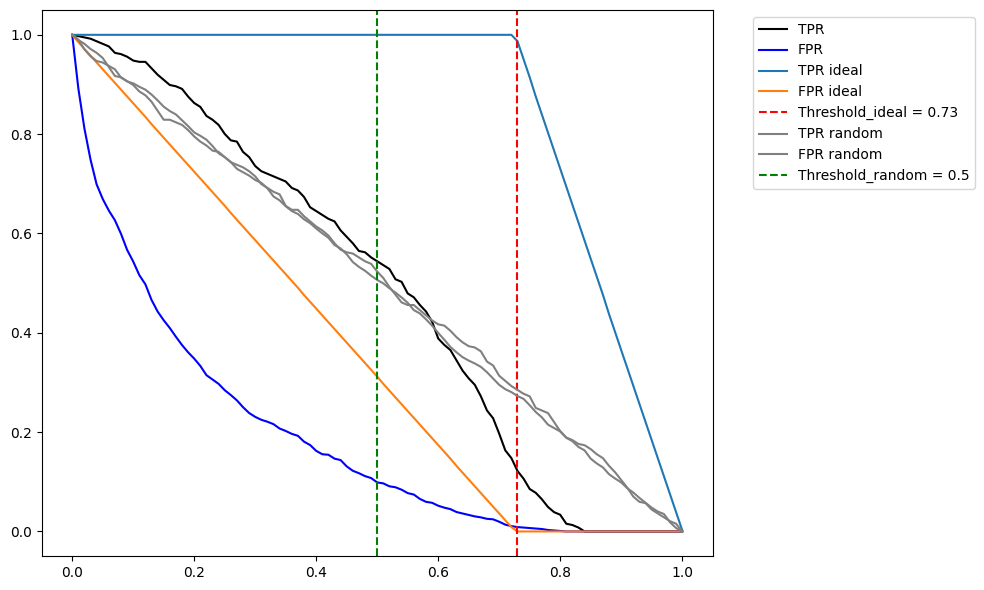

In [232]:
plt.figure(figsize=(10, 6))

threshold_ideal = round(1 - y_val.mean(), 2)
threshold_random = 0.5

plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR', color='black')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR', color='blue')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR ideal')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR ideal')
plt.axvline(x=threshold_ideal, color='red', linestyle='--', label=f'Threshold_ideal = {threshold_ideal}')

plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR random', color='grey')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR random', color='grey')
plt.axvline(x=threshold_random, color='green', linestyle='--', label=f'Threshold_random = {threshold_random}')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

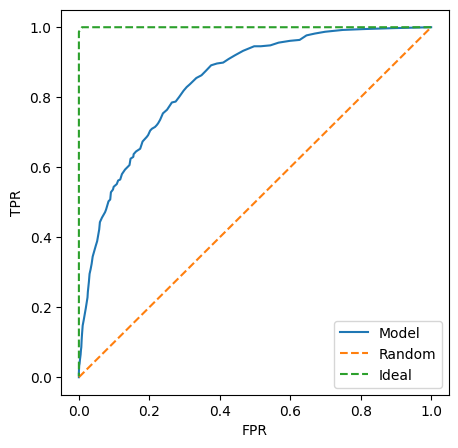

In [233]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')
plt.plot(df_ideal.fpr, df_ideal.tpr, label='Ideal', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend();

# we start with threshold 0, so we predict all positive instances, so we have 100% TPR and 100% FPR
# we end with threshold 1, so we predict all negative instances, so we have 0% TPR and 0% FPR

In [234]:
from sklearn.metrics import roc_curve

In [235]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

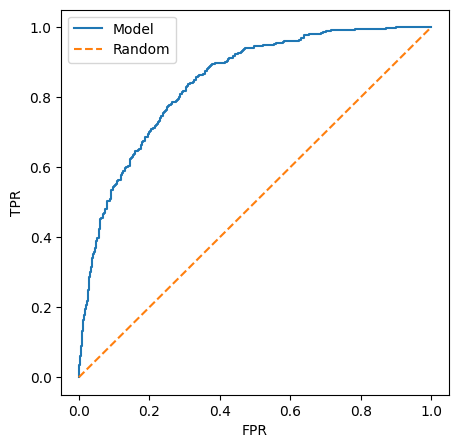

In [236]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend();

## 4.6 ROC AUC

* Area under the ROC curve - useful metric
* Interpretation of AUC

In [237]:
from sklearn.metrics import auc

In [238]:
auc(fpr, tpr)

0.8438530381535563

In [239]:
auc(df_scores.fpr, df_scores.tpr)

0.8438732975754537

In [240]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [241]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

0.8438530381535563

In [242]:
from sklearn.metrics import roc_auc_score

In [243]:
roc_auc_score(y_val, y_pred)

0.8438530381535563

In [244]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [245]:
import random

- AUC interpretation, is a probability that the model will rank a randomly chosen positive instance higher than a randomly chosen negative instance
- AUC also orders the predictions, so the model is able to rank the instances. How good the model is at ranking the instances

In [246]:
%%timeit
# pandas sample method
n = 100000
success = 0 

for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) - 1)

    if pos[pos_ind] > neg[neg_ind]:
        success = success + 1

success / n

125 ms ± 12.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [247]:
%%timeit
# numpy random method - faster
n = 100000

np.random.seed(1)
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

(pos[pos_ind] > neg[neg_ind]).mean()

1.71 ms ± 58.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## 4.7 Cross-Validation

* Evaluating the same model on different subsets of data
* Getting the average prediction and the spread within predictions

In [248]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [249]:
dv, model = train(df_train, y_train, C=0.001)

In [250]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [251]:
y_pred = predict(df_val, dv, model)

In [252]:
from sklearn.model_selection import KFold

In [187]:
#!pip install tqdm

^C


In [259]:
!where python

c:\Users\Utilizador\AppData\Local\Programs\Python\Python311\python.exe
C:\Users\Utilizador\AppData\Local\Programs\Python\Python312\python.exe
C:\Users\Utilizador\AppData\Local\Programs\Python\Python310\python.exe
C:\Users\Utilizador\AppData\Local\Microsoft\WindowsApps\python.exe


In [257]:
!python --version

Python 3.11.3


In [261]:
#from tqdm.auto import tqdm

In [262]:
n_splits = 5

for C in [0.001, 0.01, 0.1, 0.5, 1, 5, 10]:
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.001 0.825 +- 0.009
C=0.01 0.840 +- 0.009
C=0.1 0.841 +- 0.007
C=0.5 0.841 +- 0.006
C=1 0.841 +- 0.008
C=5 0.840 +- 0.008
C=10 0.841 +- 0.008


In [263]:
scores

[0.8419315336248243,
 0.8459041021056812,
 0.8336102749347782,
 0.8319830370275628,
 0.8525462018763139]

In [131]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.8572386167896259

## 4.8 Summary

* Metric - a single number that describes the performance of a model
* Accuracy - fraction of correct answers; sometimes misleading 
* Precision and recall are less misleading when we have class inbalance
* ROC Curve - a way to evaluate the performance at all thresholds; okay to use with imbalance
* K-Fold CV - more reliable estimate for performance (mean + std)

## 4.9 Explore more

* Check the precision and recall of the dummy classifier that always predict "FALSE"
* F1 score = 2 * P * R / (P + R)
* Evaluate precision and recall at different thresholds, plot P vs R - this way you'll get the precision/recall curve (similar to ROC curve)
* Area under the PR curve is also a useful metric

Other projects:

* Calculate the metrics for datasets from the previous week